# Keras에서 LSTM을 활용한 다변량 시계열 예측
# DF 넣어야 함!!!
<br><br>
### 1. TensorFlow-gpu 및 keras 설치
참고 : http://blog.daum.net/geoscience/1418 <br><br>

#### 텐서플로우 추가 (문서에서는 2.0.0 버전)
> conda install tensorflow-gpu==2.0.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


#### 케라스 추가 (문서에서는 2.2.4-tf 버전)
> conda install keras

* Anaconda prompt에서 설치해서 conda라고 붙임 kreas 설치 문제 때문에 여러번 설치해서 conda가 아닌 pip를 사용해도 괜찮은지는 모르겠음
* 다른 문서들과는 달리 여기 아래에서 keras를 사용하기 위해서는 tensorflow.keras라고 지칭해주어야 하는 문제 발생

In [2]:
from tensorflow import keras
print(keras.__version__)

2.2.4-tf


#### 사용 가능한 CPU와 GPU 장치 목록 확인
* name: "/device:GPU:0" 라고 뜨는 것이 GPU를 사용할 수 있다는 것을 의미하는 것 같음

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17147727573034521789
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9210949796
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3885751720498339050
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


<br><br>
### 2. 데이터 정제
참고 : https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
<br><br>혹시 아래가 설치되어 있지 않다면 설치
> conda install scikit-learn <br>
> conda install Pandas <br>
> conda install NumPy <br>
> conda install Matplotlib

#### 모듈 호출

In [4]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import LabelEncoder #문자열로 된 컬럼이 있을 때
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

#### 데이터 준비
데이터 로드

In [5]:
dataset = read_csv("C:/Users/ty009/문서/ITRC/ITRC_1F_GROUP_12.csv", header=0, index_col=0)
values = dataset.values

plot로 데이터 시각화

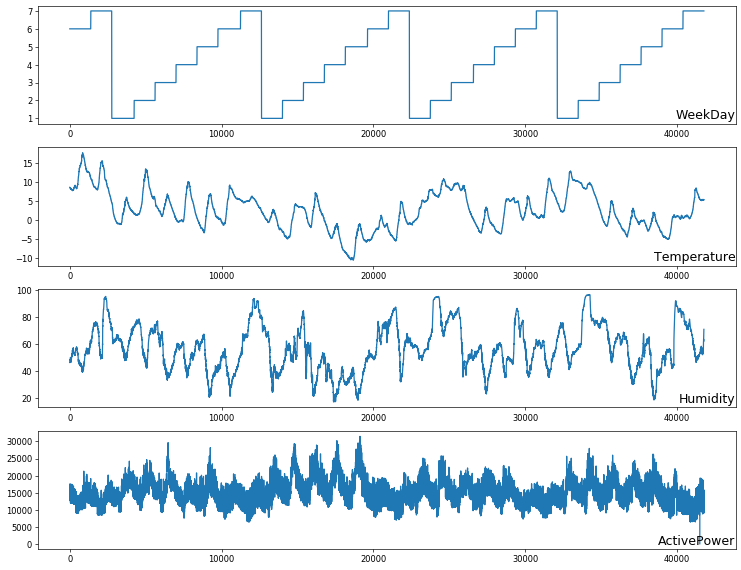

In [6]:
groups = [0,1,2,3]
i = 1
plt.figure(figsize=(15, 12), dpi= 60, facecolor='w', edgecolor='k')
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group], y=0, loc='right', fontsize=15)
    i += 1
plt.show()

<br><br>
## 3. 다변량 예측 모델
####  데이터 준비
<br>
series_to_supervised() : 시계열 데이터셋을 supervised learning 문제로 변경하기 위한 함수

* data : 목록 또는 2D NumPy 배열 형식의 관측치<br>

* n_in : (입력값) 지연 관찰 수로, 값은 1에서 len(data) 사잇값. 기본값은 1<br>

* n_out : 출력(y)되는 관측치의 수인 것 같음. 값은 0에서 len(data)-1 사잇값. 기본값은 1. 선택 사항임<br>

* dropnan : NaN 값인 행을 삭제할지 여부를 나타내는 부울 값. 기본값은 True이며, 역시 선택사항<br>

* return : 지도학습을 위해 프래임 된 pandas DataFrame

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()
    df[3] = df[3].fillna(method = 'pad')
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()
    
    ## input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' %(j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

supervised learning 틀에 넣기

* 차분 : 연이은 관측값들의 차이를 계산하는 것으로, 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만듦 (추세나 계절성의 감소)<br>
* 2차 차분 : 차분한 데이터가 정상성이 없다고 판단될 때 이를 위해 다시 차분하는 것<br>
* 계절성 차분 : 관측치와, 같은 계절의 이전 관측값과의 차이

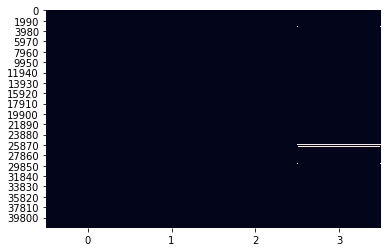

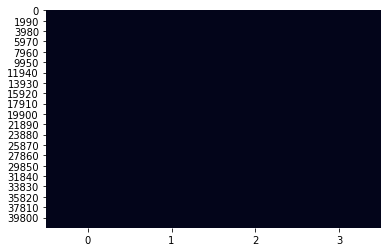

     var4(t-5)    var4(t-4)    var4(t-3)    var4(t-2)    var4(t-1)  var1(t)  \
5  13238.54199  12966.06445  15570.23145  13039.69434  13053.90723      6.0   
6  12966.06445  15570.23145  13039.69434  13053.90723  14527.38379      6.0   
7  15570.23145  13039.69434  13053.90723  14527.38379  13151.25488      6.0   
8  13039.69434  13053.90723  14527.38379  13151.25488  15017.60938      6.0   
9  13053.90723  14527.38379  13151.25488  15017.60938  13162.80957      6.0   

   var2(t)  var3(t)      var4(t)  
5      8.5     46.6  14527.38379  
6      8.5     46.7  13151.25488  
7      8.5     46.6  15017.60938  
8      8.5     46.4  13162.80957  
9      8.5     46.5  13532.61523  
values  41775 reframed  41770


In [8]:
reframed = series_to_supervised(values, 5, 1, False)
reframed = reframed.drop(reframed.index[0:5])
for i in range(5):
    reframed = reframed.drop(reframed.columns[0+i:3+i], axis='columns')  #여기 숫자는 고정!
print(reframed.head())
print("values ", len(values), "reframed ", len(reframed))

<br>데이터를 모두 float(소수) 형식으로 변경하여 0에서 1 사이 값으로 만들고 위에서 만든 함수를 적용시킴<br><br>

문자열로 구성된 컬럼이 있어 예측을 위해 숫자 형식으로 변환할 필요가 있을 때 아래의 코드의 처음에 다음을 추가한다.<br>
encoder = LabelEncoder() <br>
values[:,1] = encoder.fit_transform(values[:,1])<br>

* 위의 코드와 위치 변경됨

In [9]:
# ensure all data is float
reframed = reframed.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

In [10]:
print(scaled)

[[0.42027563 0.41162544 0.49429828 ... 0.6749116  0.36901766 0.46119165]
 [0.41162544 0.49429828 0.41396293 ... 0.6749116  0.37027717 0.41750458]
 [0.49429828 0.41396293 0.41441414 ... 0.6749116  0.36901766 0.47675455]
 ...
 [0.29401302 0.3732083  0.3668134  ... 0.56183743 0.6511336  0.298646  ]
 [0.3732083  0.3668134  0.365988   ... 0.56183743 0.6662469  0.29520154]
 [0.3668134  0.365988   0.50222754 ... 0.56183743 0.6763225  0.29710633]]


<br><br>
#### 모델 정의 및 맞춤

준비된 dataset을 train data와 validation data, test data로 분할함<br>
데이터 정제 과정에서 12시~13시를 제거했으므로 하루를 23시로 계산함

In [11]:
values = scaled
n_train = 14 * 23 * 60
n_validation = n_train + 7 * 23 * 60
train = values[:n_train, :]
validation = values[n_train:n_validation, :]
test = values[n_validation:, :]

train data와 test data의 입력값(X)과 출력값(Y)을 설정함<br>
* var1(Active Power)은 Y에, 나머지는 모두 X에 넣음

In [12]:
train_X, train_Y = train[:, :-1], train[:, -1]
validation_X, validation_Y = validation[:, :-1], validation[:, -1]
test_X, test_Y = test[:, :-1], test[:, -1]

In [13]:
print(train_X.shape, train_Y.shape, validation_X.shape, validation_Y.shape, test_X.shape, test_Y.shape)

(19320, 8) (19320,) (9660, 8) (9660,) (12790, 8) (12790,)


입력 내용을 3D로 변경 [samples, timesteps, features]<br>

* [samples, timesteps, features]가 층, 행, 열일 거라고 생각하고 있음<br>

다음을 실행하면 train data와 validation data, test data가 인쇄된다.

In [14]:
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
validation_X = validation_X.reshape(validation_X.shape[0], 1, validation_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
print(train_X.shape, train_Y.shape, validation_X.shape, validation_Y.shape)
print("train_X")
print(train_X)

(19320, 1, 8) (19320,) (9660, 1, 8) (9660,)
train_X
[[[0.42027563 0.41162544 0.49429828 ... 0.8333333  0.6749116  0.36901766]]

 [[0.41162544 0.49429828 0.41396293 ... 0.8333333  0.6749116  0.37027717]]

 [[0.49429828 0.41396293 0.41441414 ... 0.8333333  0.6749116  0.36901766]]

 ...

 [[0.5406565  0.54842377 0.4851374  ... 0.6666667  0.20848058 0.26322424]]

 [[0.54842377 0.4851374  0.4808093  ... 0.6666667  0.20848058 0.26700258]]

 [[0.4851374  0.4808093  0.48252493 ... 0.6666667  0.20848058 0.27078086]]]


모델 디자인<br>
Active Power를 예측하기 위해 첫번째 hidden layer와 output layer에 뉴런을 정의할 것<br>
* LSTM(): lstm 모델 생성, 입력값은 각각 timestep과 feature<br>
* Dense() : 예측하고자 하는 target의 개수<br>     첫번째 값 : 노드의 개수(원하는 숫자로 하되, 너무 적으면 학습이 잘 되지 않으니 5 이상의 정수로 한다),<br> input_shape : 입력값의 모양. (1,)일 때는 한 개씩 여러번 해야 하기 때문에 정하지 않았다는 의미
* compile : 모델을 어떻게 학습할지 정하는 곳
* 연속적인 예측을 하는 것이기 때문에 loss function은 mean_squared_error, optimizer는 adam을 자주 사용한다고 함<br>
* compile 기본 형식 : compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None) https://keras.io/ko/models/sequential/

In [15]:
j = 0
slListStr = ["SimpleRNN", "LSTM", "GRU"]

for i in [SimpleRNN, LSTM, GRU]:
    globals()["%s_slModel" %slListStr[j]] = Sequential()
    globals()["%s_slModel" %slListStr[j]].add(i(30, activation='softmax', input_shape=(train_X.shape[1], train_X.shape[2])))
    globals()["%s_slModel" %slListStr[j]].add(Dropout(0.2))
    globals()["%s_slModel" %slListStr[j]].add(Dense(30, activation='elu'))
    globals()["%s_slModel" %slListStr[j]].add(Dropout(0.2))
    globals()["%s_slModel" %slListStr[j]].add(Dense(1, activation='sigmoid'))
    globals()["%s_slModel" %slListStr[j]].compile(loss='mse', metric=['accuracy'], optimizer='adam')
    globals()["%s_slModel" %slListStr[j]].summary()
    j += 1
    print("\n\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30)                1170      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 2,131
Trainable params: 2,131
Non-trainable params: 0
_________________________________________________________________



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 

모델 fitting<br>

* 첫번째 값 : 우리가 알 수 있는 데이터<br>
* 두번째 값 : 첫번째 값을 통해 우리가 예측하고싶은 데이터. 즉 정답<br>
* epochs : 몇 번 학습할지 정함<br>
* verbose : 학습 진행도를 보여줄지 말지, 어느정도 보여줄지 정함

In [16]:
#history = model.fit(train_X, train_Y, epochs=20, batch_size=72, verbose=2)
j = 0
for i in [SimpleRNN, LSTM, GRU]:
    print("\n\nStudy %s" %slListStr[j])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    globals()["%s_history" %slListStr[j]] = globals()["%s_slModel" %slListStr[j]].fit(train_X, train_Y, epochs=100, batch_size=50, validation_data=(validation_X, validation_Y), verbose=1, callbacks=[early_stopping])
    j += 1



Study SimpleRNN
Train on 19320 samples, validate on 9660 samples
Epoch 1/100
19320/19320 [==============================] - 3s 163us/sample - loss: 0.0096 - val_loss: 0.0045
Epoch 2/100
19320/19320 [==============================] - 2s 86us/sample - loss: 0.0061 - val_loss: 0.0042
Epoch 3/100
19320/19320 [==============================] - 2s 85us/sample - loss: 0.0056 - val_loss: 0.0040
Epoch 4/100
19320/19320 [==============================] - 2s 85us/sample - loss: 0.0053 - val_loss: 0.0039
Epoch 5/100
19320/19320 [==============================] - 2s 87us/sample - loss: 0.0049 - val_loss: 0.0036
Epoch 6/100
19320/19320 [==============================] - 2s 93us/sample - loss: 0.0047 - val_loss: 0.0035
Epoch 7/100
19320/19320 [==============================] - 2s 85us/sample - loss: 0.0045 - val_loss: 0.0035
Epoch 8/100
19320/19320 [==============================] - 2s 85us/sample - loss: 0.0044 - val_loss: 0.0035
Epoch 9/100
19320/19320 [==============================] - 2s 84us/s

Epoch 38/100
19320/19320 [==============================] - 2s 110us/sample - loss: 0.0036 - val_loss: 0.0032
Epoch 39/100
19320/19320 [==============================] - 2s 111us/sample - loss: 0.0036 - val_loss: 0.0032
Epoch 40/100
19320/19320 [==============================] - 2s 112us/sample - loss: 0.0036 - val_loss: 0.0033
Epoch 41/100
19320/19320 [==============================] - 2s 111us/sample - loss: 0.0036 - val_loss: 0.0032
Epoch 42/100
19320/19320 [==============================] - 2s 118us/sample - loss: 0.0036 - val_loss: 0.0032
Epoch 43/100
19320/19320 [==============================] - 2s 111us/sample - loss: 0.0036 - val_loss: 0.0032
Epoch 44/100
19320/19320 [==============================] - 2s 110us/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 45/100
19320/19320 [==============================] - 2s 111us/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 46/100
19320/19320 [==============================] - 2s 111us/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 47/1

plot 그리기

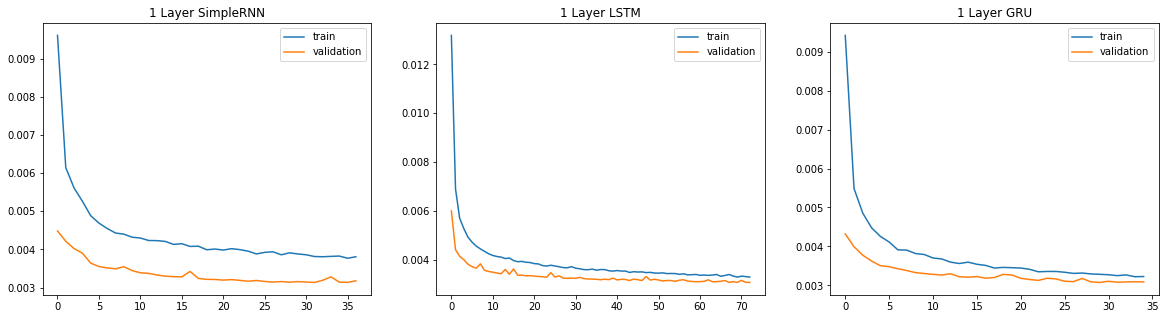

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(SimpleRNN_history.history['loss'], label='train')
ax[0].plot(SimpleRNN_history.history['val_loss'], label='validation')
ax[0].title.set_text('1 Layer SimpleRNN')
ax[0].legend()

ax[1].plot(LSTM_history.history['loss'], label='train')
ax[1].plot(LSTM_history.history['val_loss'], label='validation')
ax[1].title.set_text('1 Layer LSTM')
ax[1].legend()

ax[2].plot(GRU_history.history['loss'], label='train')
ax[2].plot(GRU_history.history['val_loss'], label='validation')
ax[2].title.set_text('1 Layer GRU')
ax[2].legend()

plt.show()

<br><br>
## 4. vaildation data 예측&정확도 측정
#### validation 예측 생성

In [18]:
SimpleRNN_vali_yhat = SimpleRNN_slModel.predict(validation_X)
LSTM_vali_yhat = LSTM_slModel.predict(validation_X)
GRU_vali_yhat = GRU_slModel.predict(validation_X)

#### test 예측 생성

In [19]:
SimpleRNN_test_yhat = SimpleRNN_slModel.predict(test_X)
LSTM_test_yhat = LSTM_slModel.predict(test_X)
GRU_test_yhat = GRU_slModel.predict(test_X)

#### 데이터 형식 맞추기
이거 왜 했는지 기억이 안 남

In [20]:
validation_X = validation_X.reshape((validation_X.shape[0], validation_X.shape[2]))
print(validation_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X)

[[0.4808093  0.48252493 0.4795765  ... 0.6666667  0.204947   0.2732998 ]
 [0.48252493 0.4795765  0.6216732  ... 0.6666667  0.204947   0.2732998 ]
 [0.4795765  0.6216732  0.47778282 ... 0.6666667  0.204947   0.2732998 ]
 ...
 [0.5031938  0.5615327  0.48615235 ... 0.6666667  0.5547703  0.39924437]
 [0.5615327  0.48615235 0.6061276  ... 0.6666667  0.5547703  0.4005038 ]
 [0.48615235 0.6061276  0.560295   ... 0.6666667  0.5547703  0.39798498]]
[[0.6061276  0.560295   0.55261236 ... 0.6666667  0.5547703  0.4005038 ]
 [0.560295   0.55261236 0.6126712  ... 0.6666667  0.5547703  0.4042822 ]
 [0.55261236 0.6126712  0.47216418 ... 0.6666667  0.55123675 0.3954661 ]
 ...
 [0.29401302 0.3732083  0.3668134  ... 1.0000001  0.56183743 0.6511336 ]
 [0.3732083  0.3668134  0.365988   ... 1.0000001  0.56183743 0.6662469 ]
 [0.3668134  0.365988   0.50222754 ... 1.0000001  0.56183743 0.6763225 ]]


In [21]:
validation_y = np.array(validation_Y).reshape(validation_Y.shape[0],1)
print(validation_y)
test_y = np.array(test_Y).reshape(test_Y.shape[0],1)
print(test_y)

[[0.46159217]
 [0.44475073]
 [0.52595794]
 ...
 [0.55261236]
 [0.6126712 ]
 [0.47216418]]
[[0.5017518 ]
 [0.49226385]
 [0.5127136 ]
 ...
 [0.298646  ]
 [0.29520154]
 [0.29710633]]


#### 예측값 Plot

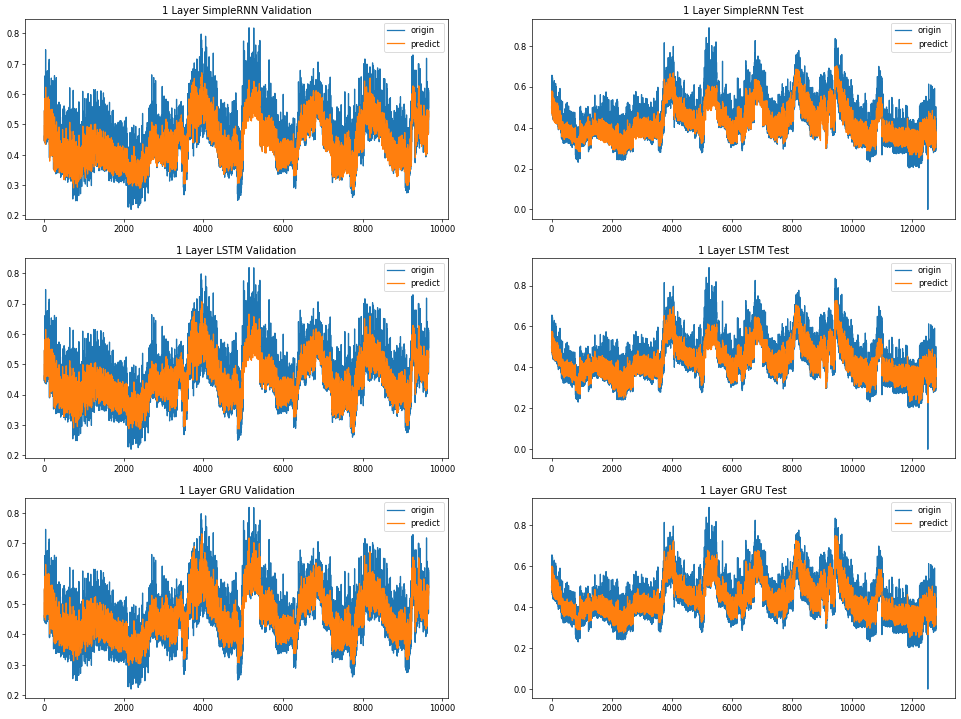

In [22]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15), dpi= 60, facecolor='w', edgecolor='k')

# Simple RNN
ax[0][0].plot(validation_y, label='origin')
ax[0][0].plot(SimpleRNN_vali_yhat, label='predict')
ax[0][0].title.set_text('1 Layer SimpleRNN Validation')
ax[0][0].legend(loc='upper right')

ax[0][1].plot(test_y, label='origin')
ax[0][1].plot(SimpleRNN_test_yhat, label='predict')
ax[0][1].title.set_text('1 Layer SimpleRNN Test')
ax[0][1].legend(loc='upper right')


# LSTM
ax[1][0].plot(validation_y, label='origin')
ax[1][0].plot(LSTM_vali_yhat, label='predict')
ax[1][0].title.set_text('1 Layer LSTM Validation')
ax[1][0].legend(loc='upper right')

ax[1][1].plot(test_y, label='origin')
ax[1][1].plot(LSTM_test_yhat, label='predict')
ax[1][1].title.set_text('1 Layer LSTM Test')
ax[1][1].legend(loc='upper right')


# GRU
ax[2][0].plot(validation_y, label='origin')
ax[2][0].plot(GRU_vali_yhat, label='predict')
ax[2][0].title.set_text('1 Layer GRU Validation')
ax[2][0].legend(loc='upper right')

ax[2][1].plot(test_y, label='origin')
ax[2][1].plot(GRU_test_yhat, label='predict')
ax[2][1].title.set_text('1 Layer GRU Test')
ax[2][1].legend(loc='upper right')

plt.show();

#### 평가

In [23]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

for i in ["SimpleRNN", "LSTM", "GRU"]:
    print("1 Layer %s Model Validation Evaluation\n" %i)
    MAE_vail =  mean_absolute_error(validation_y, globals()["%s_vali_yhat" %i])
    MSE_vail = mean_squared_error(validation_y, globals()["%s_vali_yhat" %i])
    RMSE_vail = np.sqrt(MSE_vail)
    MSLE_vail = mean_squared_log_error(validation_y, globals()["%s_vali_yhat" %i])
    RMSLE_vail = np.sqrt(mean_squared_log_error(validation_y, globals()["%s_vali_yhat" %i]))
    R2_vail = r2_score(validation_y, globals()["%s_vali_yhat" %i])
    MAPE_vail = np.mean(np.abs((globals()["%s_vali_yhat" %i] - validation_y) / globals()["%s_vali_yhat" %i])) * 100
    
    MAE_test =  mean_absolute_error(test_y, globals()["%s_test_yhat" %i])
    MSE_test = mean_squared_error(test_y, globals()["%s_test_yhat" %i])
    RMSE_test = np.sqrt(MSE_test)
    MSLE_test = mean_squared_log_error(test_y, globals()["%s_test_yhat" %i])
    RMSLE_test = np.sqrt(mean_squared_log_error(test_y, globals()["%s_test_yhat" %i]))
    R2_test = r2_score(test_y, globals()["%s_test_yhat" %i])
    MAPE_test = np.mean(np.abs((globals()["%s_test_yhat" %i] - test_y) / globals()["%s_test_yhat" %i])) * 100
    
    print("\t<Validation>\t<Test>")
    print("MAE\t%.10f"%MAE_vail, "\t%.10f"%MAE_test)
    print("MSE\t%.10f"%MSE_vail, "\t%.10f"%MSE_test)
    print("RMSE\t%.10f"%RMSE_vail, "\t%.10f"%RMSE_test)
    print("MSLE\t%.10f"%MSLE_vail, "\t%.10f"%MSLE_test)
    print("RMSLE\t%.10f"%RMSLE_vail, "\t%.10f"%RMSLE_test)
    print("MAPE\t%.10f"%MAPE_vail, "\t%.10f"%MAPE_test)
    print("R2\t%.10f"%R2_vail, "\t%.10f"%R2_test)
    print("\n\n")

1 Layer SimpleRNN Model Validation Evaluation

	<Validation>	<Test>
MAE	0.0441915952 	0.0421338901
MSE	0.0031745832 	0.0029548109
RMSE	0.0563434400 	0.0543581732
MSLE	0.0014691602 	0.0014000667
RMSLE	0.0383296274 	0.0374174640
MAPE	10.0808329880 	10.0716099143
R2	0.6178823538 	0.7032239589



1 Layer LSTM Model Validation Evaluation

	<Validation>	<Test>
MAE	0.0442271046 	0.0427514240
MSE	0.0030901711 	0.0029462867
RMSE	0.0555893071 	0.0542797074
MSLE	0.0014372703 	0.0014070548
RMSLE	0.0379113480 	0.0375107303
MAPE	9.8891071975 	10.0333862007
R2	0.6280428385 	0.7040801352



1 Layer GRU Model Validation Evaluation

	<Validation>	<Test>
MAE	0.0447353907 	0.0434932411
MSE	0.0030888307 	0.0029561908
RMSE	0.0555772483 	0.0543708652
MSLE	0.0014483328 	0.0014250146
RMSLE	0.0380569696 	0.0377493650
MAPE	9.9018119276 	10.1047039032
R2	0.6282041798 	0.7030853814





끝